### Running Unitary gate $U(\theta, \phi, \lambda)$ with SV1 does only work with own ``transpile_U`` function

In [1]:
import numpy as np

from braket.aws import AwsDevice
from braket.circuits import Circuit
from braket.circuits.circuit import Gate, Instruction
from braket.circuits.gates import U, PhaseShift, Ry
from braket.device_schema import DeviceActionType
from braket.parametric import FreeParameter
from braket.devices import LocalSimulator

from transpile_U_gate import transpile_U

import sys
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from braket_estimator import BraketEstimator

In [2]:
device = LocalSimulator()
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

In [3]:
circ = Circuit().rx(0, FreeParameter('alpha')).u(0, 0.15, 0.34, 0.52).cnot(0, 1).u(1, 0.15, 0.34, 0.52).rx(1, FreeParameter('beta'))

In [4]:
if 'u' not in device.properties.action[DeviceActionType.OPENQASM].supportedOperations:
    print("U gate not supported")
    print('Original circuit:', print(circ))
    circuit = transpile_U(circuit=circ)
    print('\nTranspiled circuit:', print(circuit))
    

U gate not supported
T  : |    0    |         1         |2|         3         |   4    |
                                                                   
q0 : -Rx(alpha)-U(0.15, 0.34, 0.52)-C------------------------------
                                    |                              
q1 : -------------------------------X-U(0.15, 0.34, 0.52)-Rx(beta)-

T  : |    0    |         1         |2|         3         |   4    |

Unassigned parameters: [alpha, beta].
Original circuit: None
T  : |    0    |     1     |   2    |     3     |4|     5     |   6    |     7     |   8    |
                                                                                             
q0 : -Rx(alpha)-PHASE(0.15)-Ry(0.34)-PHASE(0.52)-C-------------------------------------------
                                                 |                                           
q1 : --------------------------------------------X-PHASE(0.15)-Ry(0.34)-PHASE(0.52)-Rx(beta)-

T  : |    0    |     1     |   2    |

In [5]:
### WORKS
device = LocalSimulator()
result = device.run(
    circ, 
    shots=1000, 
    inputs={
        'alpha': 0.5, 
        'beta': np.pi / 2
    }
).result()
print('Results with LocalSimulator:', result.measurement_counts) 

Results with LocalSimulator: Counter({'00': 491, '01': 422, '10': 50, '11': 37})


In [14]:
### Works for the transpiled circuit
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
result = device.run(
    circuit, 
    shots=1000, 
    inputs={
        'alpha': 0.5, 
        'beta': np.pi / 2
    }
).result()
print('Results with SV1 simulator:', result.measurement_counts) 

Results with SV1 simulator: Counter({'00': 553, '01': 342, '11': 67, '10': 38})


#### Use SV1 with the ``BraketEstimator``

In [7]:
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

In [8]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import ParameterVector, Parameter
from qiskit_braket_provider.providers import adapter


/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


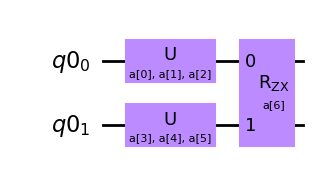

In [9]:
action_vector = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5]) # np.random.uniform(-np.pi, np.pi, 7)

q_reg = QuantumRegister(2)
baseline = np.pi * np.zeros(len(action_vector))
params = ParameterVector("a", 7)
qiskit_circuit = QuantumCircuit(q_reg, name="custom_cx")
optimal_params = np.pi * np.zeros(7)

qiskit_circuit.u(
    baseline[0] + params[0],
    baseline[1] + params[1],
    baseline[2] + params[2],
    q_reg[0],
)
qiskit_circuit.u(
    baseline[3] + params[3],
    baseline[4] + params[4],
    baseline[5] + params[5],
    q_reg[1],
)

qiskit_circuit.rzx(baseline[6] + params[6], q_reg[0], q_reg[1])
qiskit_circuit.draw("mpl")

In [10]:
braket_circuit_converted = adapter.convert_qiskit_to_braket_circuit(qiskit_circuit)

print(braket_circuit_converted)

T  : |       0        |1|2|   3   |4|5|
                                       
q0 : -U(a_0, a_1, a_2)---C---------C---
                         |         |   
q1 : -U(a_3, a_4, a_5)-H-X-Rz(a_6)-X-H-

T  : |       0        |1|2|   3   |4|5|

Unassigned parameters: [a_0, a_1, a_2, a_3, a_4, a_5, a_6].


In [11]:
if 'u' not in device.properties.action[DeviceActionType.OPENQASM].supportedOperations:
    print("U gate not supported")
    print('Original circuit:', print(braket_circuit_converted))
    transpiled_circuit = transpile_U(circuit=braket_circuit_converted)
    print('\nTranspiled circuit:', print(transpiled_circuit))
    

U gate not supported
T  : |       0        |1|2|   3   |4|5|
                                       
q0 : -U(a_0, a_1, a_2)---C---------C---
                         |         |   
q1 : -U(a_3, a_4, a_5)-H-X-Rz(a_6)-X-H-

T  : |       0        |1|2|   3   |4|5|

Unassigned parameters: [a_0, a_1, a_2, a_3, a_4, a_5, a_6].
Original circuit: None
T  : |    0     |   1   |    2     |3|4|   5   |6|7|
                                                    
q0 : -PHASE(a_0)-Ry(a_1)-PHASE(a_2)---C---------C---
                                      |         |   
q1 : -PHASE(a_3)-Ry(a_4)-PHASE(a_5)-H-X-Rz(a_6)-X-H-

T  : |    0     |   1   |    2     |3|4|   5   |6|7|

Unassigned parameters: [a_0, a_1, a_2, a_3, a_4, a_5, a_6].

Transpiled circuit: None


In [18]:
batchsize = 50

param_names = ['a_0', 'a_1', 'a_2', 'a_3', 'a_4', 'a_5', 'a_6']

if 'batchsize' in globals() and batchsize is not None and batchsize > 1:
    bound_parameters = []
    for batch in range(batchsize):
        action_vector = np.random.uniform(-np.pi, np.pi, 7)
        bound_parameters.append(dict(zip(param_names, action_vector)))
else:
    bound_parameters = dict(zip(param_names, action_vector))


observables = [
    ('II', 0.25), ('IZ', -0.25), ('XI', 0.25), ('XZ', -0.25)
]

In [19]:
braket_estimator = BraketEstimator(device)

expvals = braket_estimator.run(
    circuit=[transpiled_circuit] * batchsize,
    observables=[observables] * batchsize,
    target_register=[[0, 1]] * batchsize,
    bound_parameters=bound_parameters,
)

expvals

array([0.0331076 , 0.37513026, 0.40864092, 0.00990721, 0.05907278,
       0.42870204, 0.0018287 , 0.08920383, 0.06832672, 0.04153485,
       0.87062241, 0.36047073, 0.12231512, 0.07479852, 0.05900242,
       0.73433085, 0.03229835, 0.07375165, 0.09580154, 0.11597838,
       0.30247735, 0.09216081, 0.259127  , 0.22855103, 0.91291124,
       0.33685342, 0.32639521, 0.42642537, 0.15926862, 0.4904219 ,
       0.02942884, 0.38006527, 0.06314235, 0.19640643, 0.43903404,
       0.0249116 , 0.47995098, 0.05255246, 0.50002529, 0.4704391 ,
       0.73029051, 0.54338707, 0.50753026, 0.04372746, 0.04569487,
       0.0205131 , 0.5700273 , 0.13516012, 0.28558157, 0.37406866])

##### Run Batch with BraketEstimator and LocalSimulator

In [20]:
braket_estimator = BraketEstimator(LocalSimulator())

expvals = braket_estimator.run(
    circuit=[transpiled_circuit] * batchsize,
    observables=[observables] * batchsize,
    target_register=[[0, 1]] * batchsize,
    bound_parameters=bound_parameters,
)

expvals

array([0.0331076 , 0.37513026, 0.40864092, 0.00990721, 0.05907278,
       0.42870204, 0.0018287 , 0.08920383, 0.06832672, 0.04153485,
       0.87062241, 0.36047073, 0.12231512, 0.07479852, 0.05900242,
       0.73433085, 0.03229835, 0.07375165, 0.09580154, 0.11597838,
       0.30247735, 0.09216081, 0.259127  , 0.22855103, 0.91291124,
       0.33685342, 0.32639521, 0.42642537, 0.15926862, 0.4904219 ,
       0.02942884, 0.38006527, 0.06314235, 0.19640643, 0.43903404,
       0.0249116 , 0.47995098, 0.05255246, 0.50002529, 0.4704391 ,
       0.73029051, 0.54338707, 0.50753026, 0.04372746, 0.04569487,
       0.0205131 , 0.5700273 , 0.13516012, 0.28558157, 0.37406866])